In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the dataset
try:
    df = pd.read_csv('/content/drive/MyDrive/COM725/Strokesdataset.csv')
    display(df.head())
except FileNotFoundError:
    print("Error: Strokedataset.csv not found. Please make sure the file is in the root of your Google Drive.")

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


#data processing

In [6]:
# Analyze the relationship between smoking_status and stroke
smoking_stroke_counts = df.groupby(['smoking_status', 'stroke']).size().unstack(fill_value=0)

# Display the counts
display(smoking_stroke_counts)

stroke,0,1
smoking_status,,
formerly smoked,7272,221
never smoked,15769,284
smokes,6429,133


In [7]:
# Quick inspection
display(df.head())
print(df.shape)
df.info()

# Check missing values
print("\nMissing values per column:")
display(df.isnull().sum())

# Check duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


(43400, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB

Missing values per column:


,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,1462



Number of duplicate rows: 0


#EDA

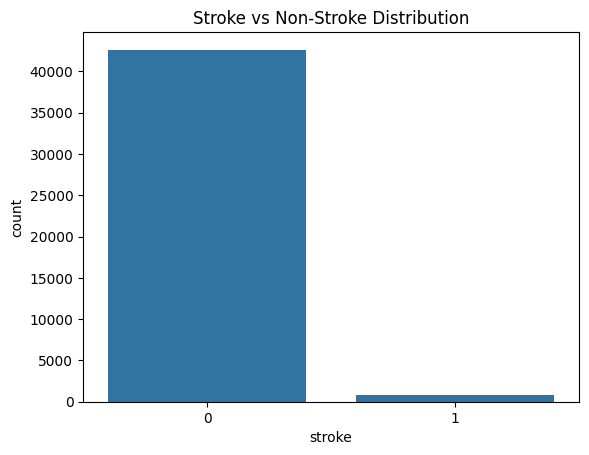

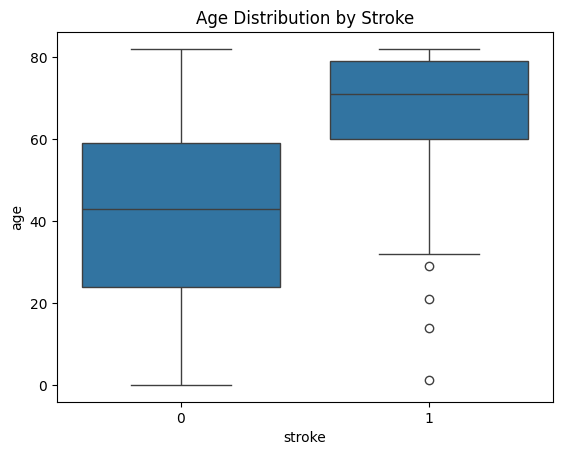

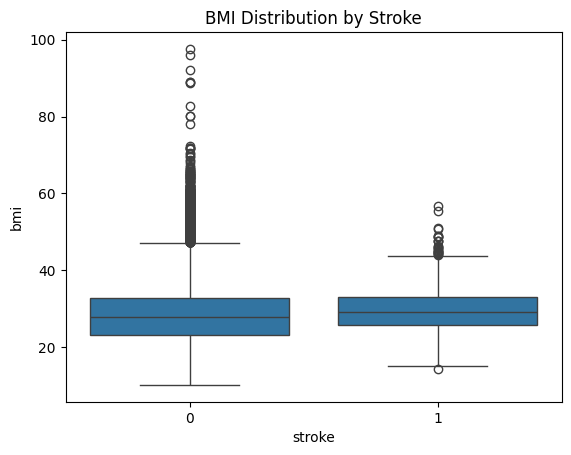

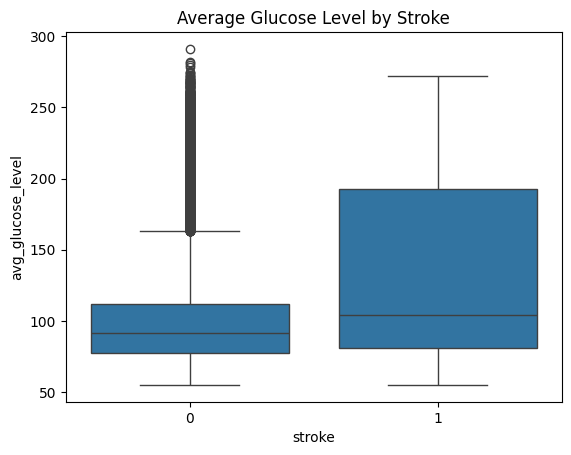

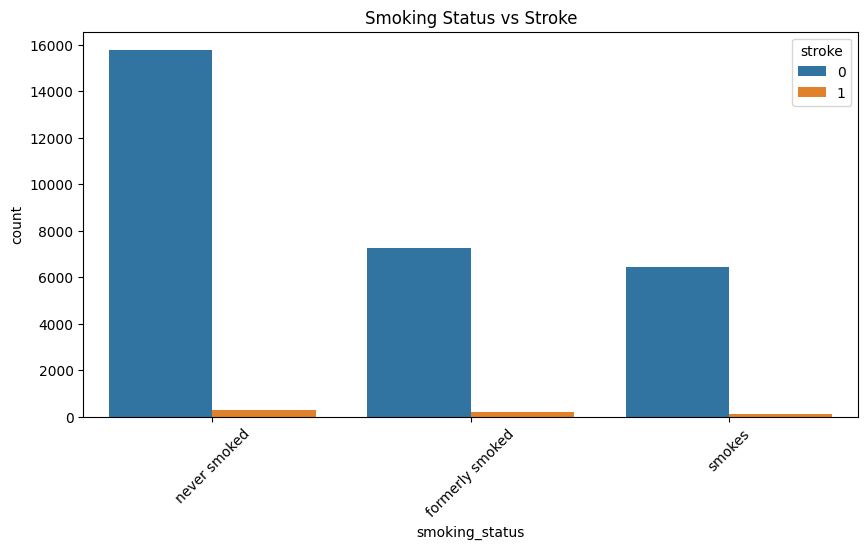

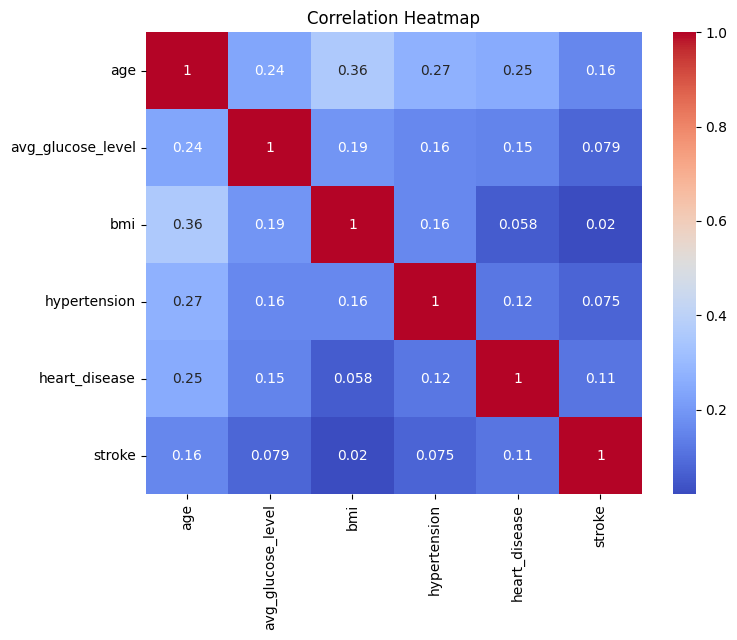

In [8]:
# Step 3: Exploratory Data Analysis (EDA)

# Target variable distribution
plt.figure()
sns.countplot(x='stroke', data=df)
plt.title('Stroke vs Non-Stroke Distribution')
plt.show()

# Age distribution by stroke
plt.figure()
sns.boxplot(x='stroke', y='age', data=df)
plt.title('Age Distribution by Stroke')
plt.show()

# BMI distribution by stroke (NaNs automatically ignored)
plt.figure()
sns.boxplot(x='stroke', y='bmi', data=df)
plt.title('BMI Distribution by Stroke')
plt.show()

# Average glucose level by stroke
plt.figure()
sns.boxplot(x='stroke', y='avg_glucose_level', data=df)
plt.title('Average Glucose Level by Stroke')
plt.show()

# Smoking status vs stroke
plt.figure(figsize=(10, 5))
sns.countplot(x='smoking_status', hue='stroke', data=df)
plt.title('Smoking Status vs Stroke')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap (numerical features)
plt.figure(figsize=(8, 6))
sns.heatmap(
    df[['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke']]
    .corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title('Correlation Heatmap')
plt.show()


#train/test split

In [9]:
# -----------------------------
# Separate features and target (if not already done)
# -----------------------------
X = df.drop(columns=['id', 'stroke'])
y = df['stroke']


In [10]:
# -----------------------------
# Train–test split (stratified)
# -----------------------------
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#imputation

In [11]:
# Step: Imputation ONLY (no scaling, no encoding)

from sklearn.impute import SimpleImputer


# -----------------------------
# Column groups
# -----------------------------
numeric_cols = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# -----------------------------
# Imputers
# -----------------------------
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# -----------------------------
# Apply imputation (fit on train only)
# -----------------------------
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]  = num_imputer.transform(X_test[numeric_cols])

X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols]  = cat_imputer.transform(X_test[categorical_cols])

# -----------------------------
# Sanity check
# -----------------------------
print("Missing values after imputation (train):")
print(X_train.isnull().sum())

print("\nMissing values after imputation (test):")
print(X_test.isnull().sum())


Missing values after imputation (train):
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

Missing values after imputation (test):
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64


#scaling

In [12]:
# Step: Scaling (Numerical Features Only)

from sklearn.preprocessing import StandardScaler

# -----------------------------
# Define numerical columns
# -----------------------------
numeric_cols = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']

# -----------------------------
# Initialise scaler
# -----------------------------
scaler = StandardScaler()

# -----------------------------
# Fit on train, transform both
# -----------------------------
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])

# -----------------------------
# Sanity check
# -----------------------------
print("Train numerical feature means (approx 0):")
print(X_train[numeric_cols].mean())

print("\nTrain numerical feature std (approx 1):")
print(X_train[numeric_cols].std())


Train numerical feature means (approx 0):
age                  3.056439e-16
avg_glucose_level    1.514406e-17
bmi                 -4.041826e-17
hypertension        -1.289291e-17
heart_disease        6.753430e-18
dtype: float64

Train numerical feature std (approx 1):
age                  1.000014
avg_glucose_level    1.000014
bmi                  1.000014
hypertension         1.000014
heart_disease        1.000014
dtype: float64


#encoding

In [13]:
# Step: Encoding (Categorical Features Only)

from sklearn.preprocessing import OneHotEncoder

# -----------------------------
# Define categorical columns
# -----------------------------
categorical_cols = [
    'gender',
    'ever_married',
    'work_type',
    'Residence_type',
    'smoking_status'
]

# -----------------------------
# Initialise encoder
# -----------------------------
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# -----------------------------
# Fit on train, transform both
# -----------------------------
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat  = encoder.transform(X_test[categorical_cols])

# -----------------------------
# Convert encoded arrays to DataFrames
# -----------------------------
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

X_train_cat_df = pd.DataFrame(
    X_train_cat,
    columns=encoded_feature_names,
    index=X_train.index
)

X_test_cat_df = pd.DataFrame(
    X_test_cat,
    columns=encoded_feature_names,
    index=X_test.index
)

# -----------------------------
# Drop original categorical columns
# -----------------------------
X_train = X_train.drop(columns=categorical_cols)
X_test  = X_test.drop(columns=categorical_cols)

# -----------------------------
# Concatenate numerical + encoded categorical features
# -----------------------------
X_train_final = pd.concat([X_train, X_train_cat_df], axis=1)
X_test_final  = pd.concat([X_test, X_test_cat_df], axis=1)

# -----------------------------
# Sanity check
# -----------------------------
print("Final train shape:", X_train_final.shape)
print("Final test shape:", X_test_final.shape)


Final train shape: (34720, 15)
Final test shape: (8680, 15)


#random forest feature importance

Top 15 important features:


,feature,importance
0,age,0.380271
3,avg_glucose_level,0.210744
4,bmi,0.190855
2,heart_disease,0.036790
7,ever_married_Yes,0.035791
1,hypertension,0.023891
5,gender_Male,0.020270
12,Residence_type_Urban,0.020049
10,work_type_Self-employed,0.019576
13,smoking_status_never smoked,0.017414


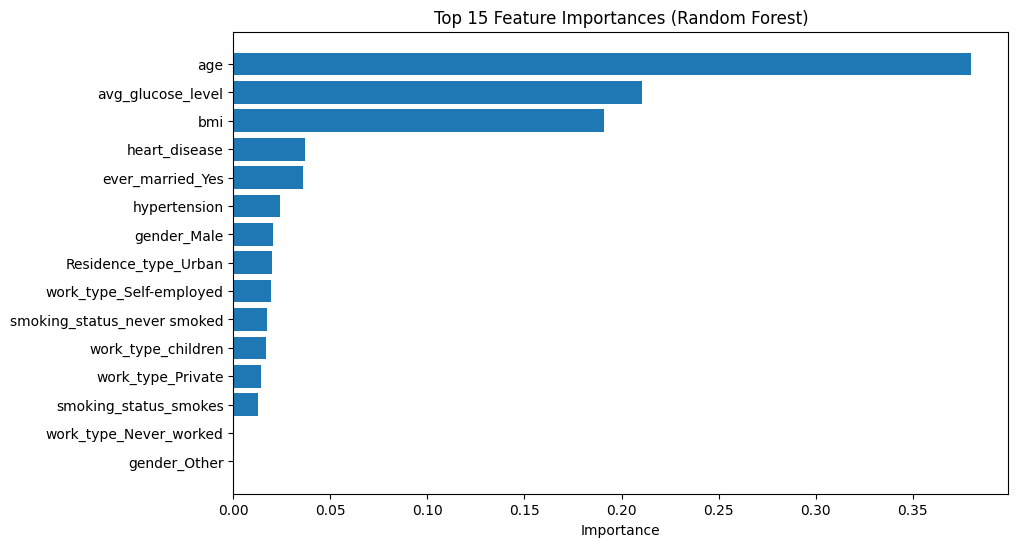

In [14]:
# Step: Random Forest Feature Importance

from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# Train Random Forest
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf.fit(X_train_final, y_train)

# -----------------------------
# Extract feature importance
# -----------------------------
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# -----------------------------
# Display top features
# -----------------------------
print("Top 15 important features:")
display(feature_importance_df.head(15))

# -----------------------------
# Optional: Visualisation
# -----------------------------
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df.head(15)['feature'],
    feature_importance_df.head(15)['importance']
)
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.show()


#feature selection

In [15]:
# Step: RF-guided Feature Selection

# Select top N features based on importance
top_n = 12
selected_features = feature_importance_df.head(top_n)['feature'].tolist()

# Subset training and test data
X_train_selected = X_train_final[selected_features]
X_test_selected  = X_test_final[selected_features]

print("Selected features:")
for f in selected_features:
    print(f)

print("\nSelected train shape:", X_train_selected.shape)
print("Selected test shape:", X_test_selected.shape)


Selected features:
age
avg_glucose_level
bmi
heart_disease
ever_married_Yes
hypertension
gender_Male
Residence_type_Urban
work_type_Self-employed
smoking_status_never smoked
work_type_children
work_type_Private

Selected train shape: (34720, 12)
Selected test shape: (8680, 12)


In [16]:
# BASE DATASET (NO SMOTE)
X_train_base = X_train_selected.copy()
X_test_base = X_test_selected.copy()

print("Base train shape:", X_train_base.shape)
print("Base test shape :", X_test_base.shape)


Base train shape: (34720, 12)
Base test shape : (8680, 12)


#modeling without smote

#lr model

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, precision_recall_curve
)
import numpy as np

print("\n===== Logistic Regression (No SMOTE) =====")

lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr.fit(X_train_base, y_train)

y_proba_lr = lr.predict_proba(X_test_base)[:, 1]

# Threshold tuning (F1)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_lr)
thresholds = thresholds[thresholds > 0]

f1_scores = [
    f1_score(y_test, (y_proba_lr >= t).astype(int))
    for t in thresholds
]

best_lr_thresh = thresholds[np.argmax(f1_scores)]
y_pred_lr = (y_proba_lr >= best_lr_thresh).astype(int)

print("Best threshold:", best_lr_thresh)
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall   :", recall_score(y_test, y_pred_lr))
print("F1-score :", f1_score(y_test, y_pred_lr))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))



===== Logistic Regression (No SMOTE) =====
Best threshold: 0.7807735459176158
Accuracy : 0.9099078341013825
Precision: 0.09043250327653997
Recall   : 0.4394904458598726
F1-score : 0.15
ROC-AUC  : 0.8394766951321677
Confusion Matrix:
 [[7829  694]
 [  88   69]]


#random forest (threshod tuned)

In [18]:
from sklearn.ensemble import RandomForestClassifier

print("\n===== Random Forest (No SMOTE) =====")

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_base, y_train)

y_proba_rf = rf.predict_proba(X_test_base)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)
thresholds = thresholds[thresholds > 0]

f1_scores = [
    f1_score(y_test, (y_proba_rf >= t).astype(int))
    for t in thresholds
]

best_rf_thresh = thresholds[np.argmax(f1_scores)]
y_pred_rf = (y_proba_rf >= best_rf_thresh).astype(int)

print("Best threshold:", best_rf_thresh)
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1-score :", f1_score(y_test, y_pred_rf))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))



===== Random Forest (No SMOTE) =====
Best threshold: 0.06666666666666667
Accuracy : 0.9221198156682028
Precision: 0.06965174129353234
Recall   : 0.267515923566879
F1-score : 0.11052631578947368
ROC-AUC  : 0.7578597739649402
Confusion Matrix:
 [[7962  561]
 [ 115   42]]


#gradient boosting (threshold tuned)

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

print("\n===== Gradient Boosting (No SMOTE) =====")

gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb.fit(X_train_base, y_train)

y_proba_gb = gb.predict_proba(X_test_base)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_gb)
thresholds = thresholds[thresholds > 0]

f1_scores = [
    f1_score(y_test, (y_proba_gb >= t).astype(int))
    for t in thresholds
]

best_gb_thresh = thresholds[np.argmax(f1_scores)]
y_pred_gb = (y_proba_gb >= best_gb_thresh).astype(int)

print("Best threshold:", best_gb_thresh)
print("Accuracy :", accuracy_score(y_test, y_pred_gb))
print("Precision:", precision_score(y_test, y_pred_gb))
print("Recall   :", recall_score(y_test, y_pred_gb))
print("F1-score :", f1_score(y_test, y_pred_gb))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))



===== Gradient Boosting (No SMOTE) =====
Best threshold: 0.09311683873093232
Accuracy : 0.9548387096774194
Precision: 0.10963455149501661
Recall   : 0.21019108280254778
F1-score : 0.14410480349344978
ROC-AUC  : 0.837242201880113
Confusion Matrix:
 [[8255  268]
 [ 124   33]]


#svm no smote

In [20]:
from sklearn.svm import LinearSVC

print("\n===== SVM (No SMOTE) =====")

svm = LinearSVC(
    C=1.0,
    class_weight='balanced',
    random_state=42,
    max_iter=5000
)

svm.fit(X_train_base, y_train)

y_pred_svm = svm.predict(X_test_base)

print("Accuracy :", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall   :", recall_score(y_test, y_pred_svm))
print("F1-score :", f1_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))



===== SVM (No SMOTE) =====
Accuracy : 0.7377880184331798
Precision: 0.053894736842105266
Recall   : 0.8152866242038217
F1-score : 0.10110584518167456
Confusion Matrix:
 [[6276 2247]
 [  29  128]]


#smote

In [21]:
# Step: Apply SMOTE on training data only

from imblearn.over_sampling import SMOTE

smote = SMOTE(
    sampling_strategy=1.0,   # balance minority = majority
    random_state=42
)

X_train_smote, y_train_smote = smote.fit_resample(
    X_train_base,
    y_train
)


print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_train_smote).value_counts())

print("\nSMOTE train shape:", X_train_smote.shape)


Before SMOTE:
stroke
0    34094
1      626
Name: count, dtype: int64

After SMOTE:
stroke
0    34094
1    34094
Name: count, dtype: int64

SMOTE train shape: (68188, 12)


#model training

#Logistic regression

Logistic Regression (SMOTE) Performance:
Accuracy : 0.7474
Precision: 0.0547
Recall   : 0.7962
F1-score : 0.1023
ROC-AUC  : 0.8406

Confusion Matrix:
[[6362 2161]
 [  32  125]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      8523
           1       0.05      0.80      0.10       157

    accuracy                           0.75      8680
   macro avg       0.52      0.77      0.48      8680
weighted avg       0.98      0.75      0.84      8680



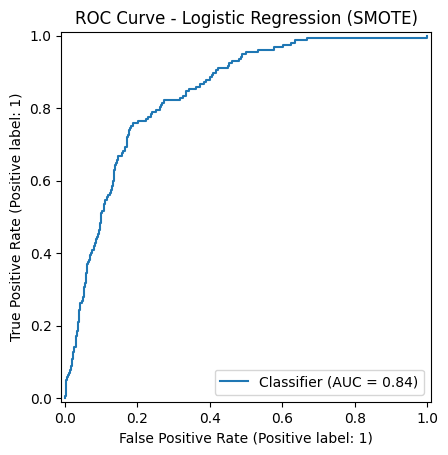

In [22]:
# Logistic Regression retraining using SMOTE-balanced data

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

# -----------------------------
# Train Logistic Regression on SMOTE data
# -----------------------------
logreg_smote = LogisticRegression(
    max_iter=1000,
    random_state=42
)

logreg_smote.fit(X_train_smote, y_train_smote)

# -----------------------------
# Predictions on ORIGINAL test set
# -----------------------------
y_pred_lr_smote = logreg_smote.predict(X_test_base)
y_proba_lr_smote = logreg_smote.predict_proba(X_test_base)[:, 1]

# -----------------------------
# Evaluation metrics
# -----------------------------
accuracy_lr = accuracy_score(y_test, y_pred_lr_smote)
precision_lr = precision_score(y_test, y_pred_lr_smote)
recall_lr = recall_score(y_test, y_pred_lr_smote)
f1_lr = f1_score(y_test, y_pred_lr_smote)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr_smote)

print("Logistic Regression (SMOTE) Performance:")
print(f"Accuracy : {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall   : {recall_lr:.4f}")
print(f"F1-score : {f1_lr:.4f}")
print(f"ROC-AUC  : {roc_auc_lr:.4f}")

# -----------------------------
# Confusion Matrix
# -----------------------------
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr_smote))

# -----------------------------
# Classification Report
# -----------------------------
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_smote))

# -----------------------------
# ROC Curve
# -----------------------------
RocCurveDisplay.from_predictions(y_test, y_proba_lr_smote)
plt.title("ROC Curve - Logistic Regression (SMOTE)")
plt.show()


#Random forest

Random Forest (SMOTE) Performance:
Accuracy : 0.9558
Precision: 0.0549
Recall   : 0.0892
F1-score : 0.0680
ROC-AUC  : 0.7928

Confusion Matrix:
[[8282  241]
 [ 143   14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      8523
           1       0.05      0.09      0.07       157

    accuracy                           0.96      8680
   macro avg       0.52      0.53      0.52      8680
weighted avg       0.97      0.96      0.96      8680



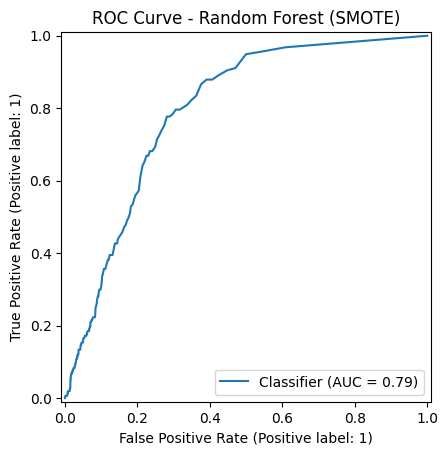

In [23]:
# Step: Random Forest retraining using SMOTE-balanced data

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

# -----------------------------
# Train Random Forest on SMOTE data
# -----------------------------
rf_smote = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_smote.fit(X_train_smote, y_train_smote)

# -----------------------------
# Predictions on ORIGINAL test set
# -----------------------------
y_pred_rf_smote = rf_smote.predict(X_test_base)
y_proba_rf_smote = rf_smote.predict_proba(X_test_base)[:, 1]

# -----------------------------
# Evaluation metrics
# -----------------------------
accuracy_rf_s = accuracy_score(y_test, y_pred_rf_smote)
precision_rf_s = precision_score(y_test, y_pred_rf_smote)
recall_rf_s = recall_score(y_test, y_pred_rf_smote)
f1_rf_s = f1_score(y_test, y_pred_rf_smote)
roc_auc_rf_s = roc_auc_score(y_test, y_proba_rf_smote)

print("Random Forest (SMOTE) Performance:")
print(f"Accuracy : {accuracy_rf_s:.4f}")
print(f"Precision: {precision_rf_s:.4f}")
print(f"Recall   : {recall_rf_s:.4f}")
print(f"F1-score : {f1_rf_s:.4f}")
print(f"ROC-AUC  : {roc_auc_rf_s:.4f}")

# -----------------------------
# Confusion Matrix
# -----------------------------
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_smote))

# -----------------------------
# Classification Report
# -----------------------------
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_smote))

# -----------------------------
# ROC Curve
# -----------------------------
RocCurveDisplay.from_predictions(y_test, y_proba_rf_smote)
plt.title("ROC Curve - Random Forest (SMOTE)")
plt.show()


Gradient Boosting (SMOTE) Performance:
Accuracy : 0.8649
Precision: 0.0590
Recall   : 0.4331
F1-score : 0.1039
ROC-AUC  : 0.8018

Confusion Matrix:
[[7439 1084]
 [  89   68]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      8523
           1       0.06      0.43      0.10       157

    accuracy                           0.86      8680
   macro avg       0.52      0.65      0.52      8680
weighted avg       0.97      0.86      0.91      8680



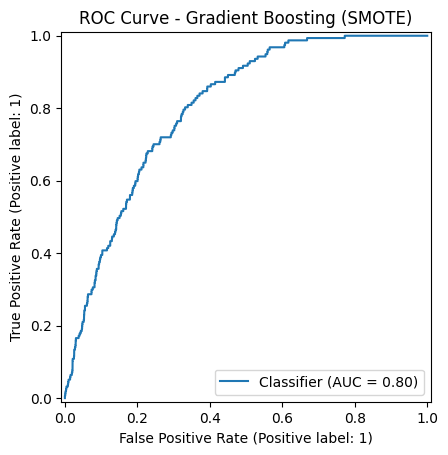

In [24]:
# Step: Gradient Boosting retraining using SMOTE-balanced data

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

# -----------------------------
# Train Gradient Boosting on SMOTE data
# -----------------------------
gb_smote = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb_smote.fit(X_train_smote, y_train_smote)

# -----------------------------
# Predictions on ORIGINAL test set
# -----------------------------
y_pred_gb_smote = gb_smote.predict(X_test_base)
y_proba_gb_smote = gb_smote.predict_proba(X_test_base)[:, 1]

# -----------------------------
# Evaluation metrics
# -----------------------------
accuracy_gb_s = accuracy_score(y_test, y_pred_gb_smote)
precision_gb_s = precision_score(y_test, y_pred_gb_smote)
recall_gb_s = recall_score(y_test, y_pred_gb_smote)
f1_gb_s = f1_score(y_test, y_pred_gb_smote)
roc_auc_gb_s = roc_auc_score(y_test, y_proba_gb_smote)

print("Gradient Boosting (SMOTE) Performance:")
print(f"Accuracy : {accuracy_gb_s:.4f}")
print(f"Precision: {precision_gb_s:.4f}")
print(f"Recall   : {recall_gb_s:.4f}")
print(f"F1-score : {f1_gb_s:.4f}")
print(f"ROC-AUC  : {roc_auc_gb_s:.4f}")

# -----------------------------
# Confusion Matrix
# -----------------------------
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb_smote))

# -----------------------------
# Classification Report
# -----------------------------
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb_smote))

# -----------------------------
# ROC Curve
# -----------------------------
RocCurveDisplay.from_predictions(y_test, y_proba_gb_smote)
plt.title("ROC Curve - Gradient Boosting (SMOTE)")
plt.show()


In [25]:
# Step: SVM retraining using SMOTE-balanced data (Linear SVM for efficiency)

from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# -----------------------------
# Train Linear SVM on SMOTE data
# -----------------------------
svm_smote = LinearSVC(
    C=1.0,
    class_weight=None,   # NOT needed because data is already balanced by SMOTE
    random_state=42,
    max_iter=5000
)

svm_smote.fit(X_train_smote, y_train_smote)

# -----------------------------
# Predictions on ORIGINAL test set
# -----------------------------
y_pred_svm_smote = svm_smote.predict(X_test_base)

# -----------------------------
# Evaluation metrics
# -----------------------------
accuracy_svm_s = accuracy_score(y_test, y_pred_svm_smote)
precision_svm_s = precision_score(y_test, y_pred_svm_smote)
recall_svm_s = recall_score(y_test, y_pred_svm_smote)
f1_svm_s = f1_score(y_test, y_pred_svm_smote)

print("SVM (SMOTE) Performance:")
print(f"Accuracy : {accuracy_svm_s:.4f}")
print(f"Precision: {precision_svm_s:.4f}")
print(f"Recall   : {recall_svm_s:.4f}")
print(f"F1-score : {f1_svm_s:.4f}")

# -----------------------------
# Confusion Matrix
# -----------------------------
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm_smote))

# -----------------------------
# Classification Report
# -----------------------------
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_smote))


SVM (SMOTE) Performance:
Accuracy : 0.7394
Precision: 0.0531
Recall   : 0.7962
F1-score : 0.0995

Confusion Matrix:
[[6293 2230]
 [  32  125]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      8523
           1       0.05      0.80      0.10       157

    accuracy                           0.74      8680
   macro avg       0.52      0.77      0.47      8680
weighted avg       0.98      0.74      0.83      8680



#FINAL MODEL COMPARISON (WITH vs WITHOUT SMOTE)

In [26]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# =============================
# Collect results
# =============================

results = []

def add_result(model_name, setup, y_true, y_pred, y_proba=None):
    row = {
        "Model": model_name,
        "Setup": setup,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }
    if y_proba is not None:
        row["ROC-AUC"] = roc_auc_score(y_true, y_proba)
    else:
        row["ROC-AUC"] = None
    results.append(row)

# =============================
# WITHOUT SMOTE
# =============================

add_result(
    "Logistic Regression",
    "No SMOTE",
    y_test,
    y_pred_lr,
    y_proba_lr
)

add_result(
    "Random Forest",
    "No SMOTE",
    y_test,
    y_pred_rf,
    y_proba_rf
)

add_result(
    "Gradient Boosting",
    "No SMOTE",
    y_test,
    y_pred_gb,
    y_proba_gb
)

add_result(
    "SVM",
    "No SMOTE",
    y_test,
    y_pred_svm,
    None
)

# =============================
# WITH SMOTE
# =============================

add_result(
    "Logistic Regression",
    "SMOTE",
    y_test,
    y_pred_lr_smote,
    y_proba_lr_smote
)

add_result(
    "Random Forest",
    "SMOTE",
    y_test,
    y_pred_rf_smote,
    y_proba_rf_smote
)

add_result(
    "Gradient Boosting",
    "SMOTE",
    y_test,
    y_pred_gb_smote,
    y_proba_gb_smote
)

add_result(
    "SVM",
    "SMOTE",
    y_test,
    y_pred_svm_smote,
    None
)

# =============================
# Create comparison table
# =============================

results_df = pd.DataFrame(results)

# Order nicely
results_df = results_df[
    ["Model", "Setup", "Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
]

print("\nFINAL MODEL COMPARISON (WITH vs WITHOUT SMOTE)\n")
display(results_df)



FINAL MODEL COMPARISON (WITH vs WITHOUT SMOTE)



,Model,Setup,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Logistic Regression,No SMOTE,0.909908,0.090433,0.439490,0.150000,0.839477
1,Random Forest,No SMOTE,0.922120,0.069652,0.267516,0.110526,0.757860
2,Gradient Boosting,No SMOTE,0.954839,0.109635,0.210191,0.144105,0.837242
3,SVM,No SMOTE,0.737788,0.053895,0.815287,0.101106,NaN
4,Logistic Regression,SMOTE,0.747350,0.054681,0.796178,0.102333,0.840600
5,Random Forest,SMOTE,0.955760,0.054902,0.089172,0.067961,0.792800
6,Gradient Boosting,SMOTE,0.864862,0.059028,0.433121,0.103896,0.801849
7,SVM,SMOTE,0.739401,0.053079,0.796178,0.099522,NaN


In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    precision_recall_curve,
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score,
    confusion_matrix
)
import numpy as np

# Train Gradient Boosting on TRAIN only
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb.fit(X_train_base, y_train)


GradientBoostingClassifier(learning_rate=0.05, n_estimators=300,
                           random_state=42)

In [28]:
# Probabilities on TRAIN set
y_train_proba_gb = gb.predict_proba(X_train_base)[:, 1]

# Precision–Recall curve (TRAIN only)
precision, recall, thresholds = precision_recall_curve(
    y_train, y_train_proba_gb
)

# Avoid zero threshold
thresholds = thresholds[thresholds > 0]

# Optimise for F1 (you can switch to recall if needed)
f1_scores = [
    f1_score(y_train, (y_train_proba_gb >= t).astype(int))
    for t in thresholds
]

best_threshold_gb = thresholds[np.argmax(f1_scores)]

print("Best GB threshold (TRAIN-tuned):", best_threshold_gb)


Best GB threshold (TRAIN-tuned): 0.13495435575513032


In [29]:
# Probabilities on TEST set
y_test_proba_gb = gb.predict_proba(X_test_base)[:, 1]

# Apply TRAIN-tuned threshold
y_test_pred_gb = (y_test_proba_gb >= best_threshold_gb).astype(int)

print("\nGradient Boosting (TRAIN-tuned threshold) – Test Performance")
print("Accuracy :", accuracy_score(y_test, y_test_pred_gb))
print("Precision:", precision_score(y_test, y_test_pred_gb, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred_gb))
print("F1-score :", f1_score(y_test, y_test_pred_gb))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba_gb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_gb))



Gradient Boosting (TRAIN-tuned threshold) – Test Performance
Accuracy : 0.9682027649769586
Precision: 0.12578616352201258
Recall   : 0.12738853503184713
F1-score : 0.12658227848101267
ROC-AUC  : 0.837242201880113

Confusion Matrix:
[[8384  139]
 [ 137   20]]


#final model selected

In [30]:
final_model = logreg_smote

# Use default 0.5 threshold OR keep as-is
# (You did not threshold-tune LR-SMOTE earlier)
final_threshold = 0.5

print("\nFINAL MODEL SELECTED:")
print("Logistic Regression WITH SMOTE")



FINAL MODEL SELECTED:
Logistic Regression WITH SMOTE


#outputs

In [31]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# =============================
# OUTPUT DIRECTORY
# =============================

OUTPUT_DIR = "/content/drive/MyDrive/COM725/outputs/"

# =============================
# FINAL PREDICTIONS
# =============================

y_test_proba = logreg_smote.predict_proba(X_test_base)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

final_predictions = pd.DataFrame({
    "id": df.loc[X_test_base.index, "id"].values,
    "true_label": y_test.values,
    "predicted_label": y_test_pred,
    "predicted_probability": y_test_proba
})

final_predictions.to_csv(
    OUTPUT_DIR + "final_predictions.csv",
    index=False
)

# =============================
# MODEL METRICS
# =============================

model_metrics = pd.DataFrame([{
    "model_name": "Logistic Regression (SMOTE)",
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred, zero_division=0),
    "recall": recall_score(y_test, y_test_pred),
    "f1_score": f1_score(y_test, y_test_pred),
    "roc_auc": roc_auc_score(y_test, y_test_proba),
    "threshold_used": 0.5
}])

model_metrics.to_csv(
    OUTPUT_DIR + "model_metrics.csv",
    index=False
)

# =============================
# CONFUSION MATRIX
# =============================

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

confusion_df = pd.DataFrame({
    "": ["Actual Negative", "Actual Positive"],
    "Predicted Negative": [tn, fn],
    "Predicted Positive": [fp, tp]
})

confusion_df.to_csv(
    OUTPUT_DIR + "confusion_matrix.csv",
    index=False
)

# =============================
# FEATURE IMPORTANCE (LR COEFFICIENTS)
# =============================

feature_importance = pd.DataFrame({
    "feature": X_train_base.columns,
    "coefficient": logreg_smote.coef_[0]
})

feature_importance["abs_coefficient"] = feature_importance["coefficient"].abs()
feature_importance = feature_importance.sort_values(
    by="abs_coefficient",
    ascending=False
)

feature_importance.to_csv(
    OUTPUT_DIR + "feature_importance.csv",
    index=False
)

print("All dashboard files saved to:", OUTPUT_DIR)


All dashboard files saved to: /content/drive/MyDrive/COM725/outputs/
